In [23]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation


In [24]:
!nvidia-smi

Sun Nov 22 14:28:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 42%   63C    P2   182W / 280W |  21757MiB / 24220MiB |     92%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 82%   87C    P2   174W / 280W |  19108MiB / 24220MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
!kill 19671  

In [25]:
# load all that we need
dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [26]:
type(dataset)

numpy.ndarray

In [27]:
dataset[0].shape

(3803,)

In [28]:
devset.shape

(59,)

In [29]:
vocab.shape

(33278,)

In [30]:
device=torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [85]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        
        self.dataset=dataset
        self.bs=batch_size
        self.shuffle=shuffle

    def __iter__(self):
        
        # concatenate your articles and build into batches
        if self.shuffle:
            np.random.shuffle(self.dataset)
        #In order to concatenate we must flatten
        concat=np.concatenate(self.dataset)
        
        #print("Shape of dataset :",self.dataset.shape)
        #now we have to choose the sequence length
        #We use BPTT as used in the paper
        
        #Now we have the seq_len
        #Now we can group the articles into sequences based on the batch size
        no_of_splits=(concat.shape[0]-1)//self.bs
        X=torch.from_numpy(concat[:no_of_splits*self.bs].reshape(self.bs,-1)).type(torch.LongTensor)
        Y=torch.from_numpy(concat[1:no_of_splits*self.bs+1].reshape(self.bs,-1)).type(torch.LongTensor)
        idx=0
        #print("No of possible splits :", no_of_splits)
        while idx < no_of_splits:
            p=np.random.random_sample()
            if p < 0.95:
                seq_len=round(np.random.normal(70,5))
            else:
                seq_len=round(np.random.normal(35,5))
            final_X=X[:,idx:idx+seq_len]
            final_Y=Y[:,idx:idx+seq_len]
            idx=idx+seq_len
            yield final_X, final_Y
       

In [86]:
# model
class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()
        
        #Embedding Layer
        #LSTM Layer
        self.embed=nn.Embedding(vocab_size,400)
        self.lstm = nn.LSTM(400,hidden_size=1150,num_layers=3,batch_first=True)
        self.linear = nn.Linear(1150, vocab_size)

    def forward(self, x,h0=None):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        x=self.embed(x)
        if h0:
            x, hidden = self.lstm(x, h0)
        else:
            x, hidden = self.lstm(x)
        self.lstm.flatten_parameters()
        x=self.linear(x)

        return x,hidden

In [87]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        inputs=inputs.to(device)
        targets=targets.to(device)
        output,_=self.model(inputs)
        loss=self.criterion(output.view(-1, output.size(2)),targets.view(-1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        del inputs
        del targets
        
        return loss
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [113]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        output,_=model(torch.LongTensor(inp).to(device))
        output=output[:,-1]#We only want the prob for the last word at the end of the sequence
        
        return output.cpu().detach().numpy()

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
            
            
        """ 
        model.eval()
        generated_words=[]
        #print("Shape of input:",inp.shape)
        output,hidden=model(torch.LongTensor(inp).to(device))
        #print("output shape:",output.shape)
        current_word=torch.argmax(output,dim=2)#B,Seq_len,Vocab_size
        #print("Current word shape :",current_word.shape)##B,Seq_len,1
        current_word=current_word[:,-1].unsqueeze(dim=1)#B,1,We need the last word only
        #print("Current word shape :",current_word.shape)
        
        generated_words.append(current_word)
        if forward > 1:
            for i in range(forward-1):
                output,hidden=model(current_word,hidden)
                current_word = torch.argmax(output,dim=2) # B,S,Vocab_size
                current_word=current_word[:,-1].unsqueeze(dim=1)#B,1,We need the last word only,with argmx and concat that
                generated_words.append(current_word)
                
        return torch.cat(generated_words,dim=1).cpu().detach().numpy()    
        

In [90]:
# TODO: define other hyperparameters here
NUM_EPOCHS = 10
BATCH_SIZE = 80

In [91]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1606081046


In [92]:
model = LanguageModel(len(vocab))
model.to(device)
#model = nn.DataParallel(model,device_ids=[4,5,6]).to(device)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [93]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()

[TRAIN]  Epoch [2/10]   Loss: 7.3301
Shape of input: (32, 20)
output shape: torch.Size([32, 20, 33278])
Current word shape : torch.Size([32, 20])
Current word shape : torch.Size([32, 1])
Shape of input: (128, 30)
output shape: torch.Size([128, 30, 33278])
Current word shape : torch.Size([128, 30])
Current word shape : torch.Size([128, 1])
[VAL]  Epoch [2/10]   Loss: 6.4843
Saving model, predictions and generated output for epoch 0 with NLL: 6.4842596
[TRAIN]  Epoch [3/10]   Loss: 6.6802
Shape of input: (32, 20)
output shape: torch.Size([32, 20, 33278])
Current word shape : torch.Size([32, 20])
Current word shape : torch.Size([32, 1])
Shape of input: (128, 30)
output shape: torch.Size([128, 30, 33278])
Current word shape : torch.Size([128, 30])
Current word shape : torch.Size([128, 1])
[VAL]  Epoch [3/10]   Loss: 5.7764
Saving model, predictions and generated output for epoch 1 with NLL: 5.7764006
[TRAIN]  Epoch [4/10]   Loss: 5.9800
Shape of input: (32, 20)
output shape: torch.Size([32

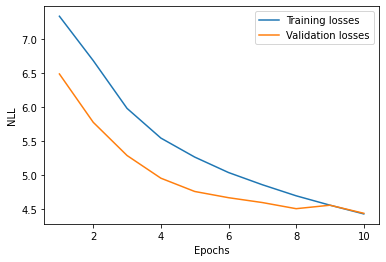

In [94]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [95]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | not able to take the ball to the ground ,
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> The first two @-@ year contract
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , " The <unk> " , which was released
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and <unk> . <eol> = = = <unk> = =
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ scale <unk> , and the <unk> of the <unk>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | and <unk> were sent to the <unk> . <eol> =
Input | Output #6: <unk> , $ 96 million USD ) 

In [112]:
!make runid=<experiments/1606081046/> epoch=<10>


/bin/sh: 1: Syntax error: end of file unexpected
